In [1]:
import sys
print(sys.version)

3.5.2 |Continuum Analytics, Inc.| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)]


Download the sqlite dataset from https://www.kaggle.com/hugomathien/soccer

In [2]:
import sqlite3
conn = sqlite3.connect('soccer.sqlite')
connection = conn.cursor()

In [3]:
for row in connection.execute('SELECT name FROM sqlite_master WHERE type="table";'):
        print(row);

('sqlite_sequence',)
('Player_Attributes',)
('Player',)
('Match',)
('League',)
('Country',)
('Team',)
('Team_Attributes',)


Div = League Division
Date = Match Date (dd/mm/yy)
HomeTeam = Home Team
AwayTeam = Away Team
FTHG = Full Time Home Team Goals
FTAG = Full Time Away Team Goals
FTR = Full Time Result (H=Home Win, D=Draw, A=Away Win)
HTHG = Half Time Home Team Goals
HTAG = Half Time Away Team Goals
HTR = Half Time Result (H=Home Win, D=Draw, A=Away Win)

Key to 1X2 (match) betting odds data:

B365H = Bet365 home win odds
B365D = Bet365 draw odds
B365A = Bet365 away win odds
BSH = Blue Square home win odds
BSD = Blue Square draw odds
BSA = Blue Square away win odds
BWH = Bet&Win home win odds
BWD = Bet&Win draw odds
BWA = Bet&Win away win odds
GBH = Gamebookers home win odds
GBD = Gamebookers draw odds
GBA = Gamebookers away win odds
IWH = Interwetten home win odds
IWD = Interwetten draw odds
IWA = Interwetten away win odds
LBH = Ladbrokes home win odds
LBD = Ladbrokes draw odds
LBA = Ladbrokes away win odds
PSH = Pinnacle home win odds
PSD = Pinnacle draw odds
PSA = Pinnacle away win odds
SOH = Sporting Odds home win odds
SOD = Sporting Odds draw odds
SOA = Sporting Odds away win odds
SBH = Sportingbet home win odds
SBD = Sportingbet draw odds
SBA = Sportingbet away win odds
SJH = Stan James home win odds
SJD = Stan James draw odds
SJA = Stan James away win odds
SYH = Stanleybet home win odds
SYD = Stanleybet draw odds
SYA = Stanleybet away win odds
VCH = VC Bet home win odds
VCD = VC Bet draw odds
VCA = VC Bet away win odds
WHH = William Hill home win odds
WHD = William Hill draw odds
WHA = William Hill away win odds

Bb1X2 = Number of BetBrain bookmakers used to calculate match odds averages and maximums
BbMxH = Betbrain maximum home win odds
BbAvH = Betbrain average home win odds
BbMxD = Betbrain maximum draw odds
BbAvD = Betbrain average draw win odds
BbMxA = Betbrain maximum away win odds
BbAvA = Betbrain average away win odds

In [4]:
bettingService = "WH"
#IW

matches = []
result = connection.execute('SELECT '+bettingService+'H, '+bettingService+'D, '+bettingService+'A, home_team_goal, away_team_goal FROM Match')

for obj in result:
    outcome = 0.5
    if obj[3] - obj[4] >= 1:
        outcome = 1
    if obj[3] - obj[4] <= -1:
        outcome = 0
    
    isValid = True
    for value in obj:
        if value == None:
            isValid = False
            break
    
    if isValid:
        matches.append({"odds":[obj[0], obj[1], obj[2]], "outcome":[outcome], "goals":[obj[3], obj[4]]})

In [5]:
import numpy as np

for match in matches:
    match['probabilities'] = np.ones(3) / match['odds']
    match['n_probabilities'] = (np.ones(3) / match['odds']) / np.sum(np.ones(3) / match['odds'])

In [6]:
x = []
y = []
c = []

for match in matches:
    x.append(match['n_probabilities'][0]);
    y.append(match['n_probabilities'][2]);
    if match['outcome'][0] == 0 :
        c.append('red');
    if match['outcome'][0] == 1 :
        c.append('green');
    if match['outcome'][0] == 0.5 :
        c.append('grey');

In [7]:
import matplotlib
import matplotlib.pyplot as plt

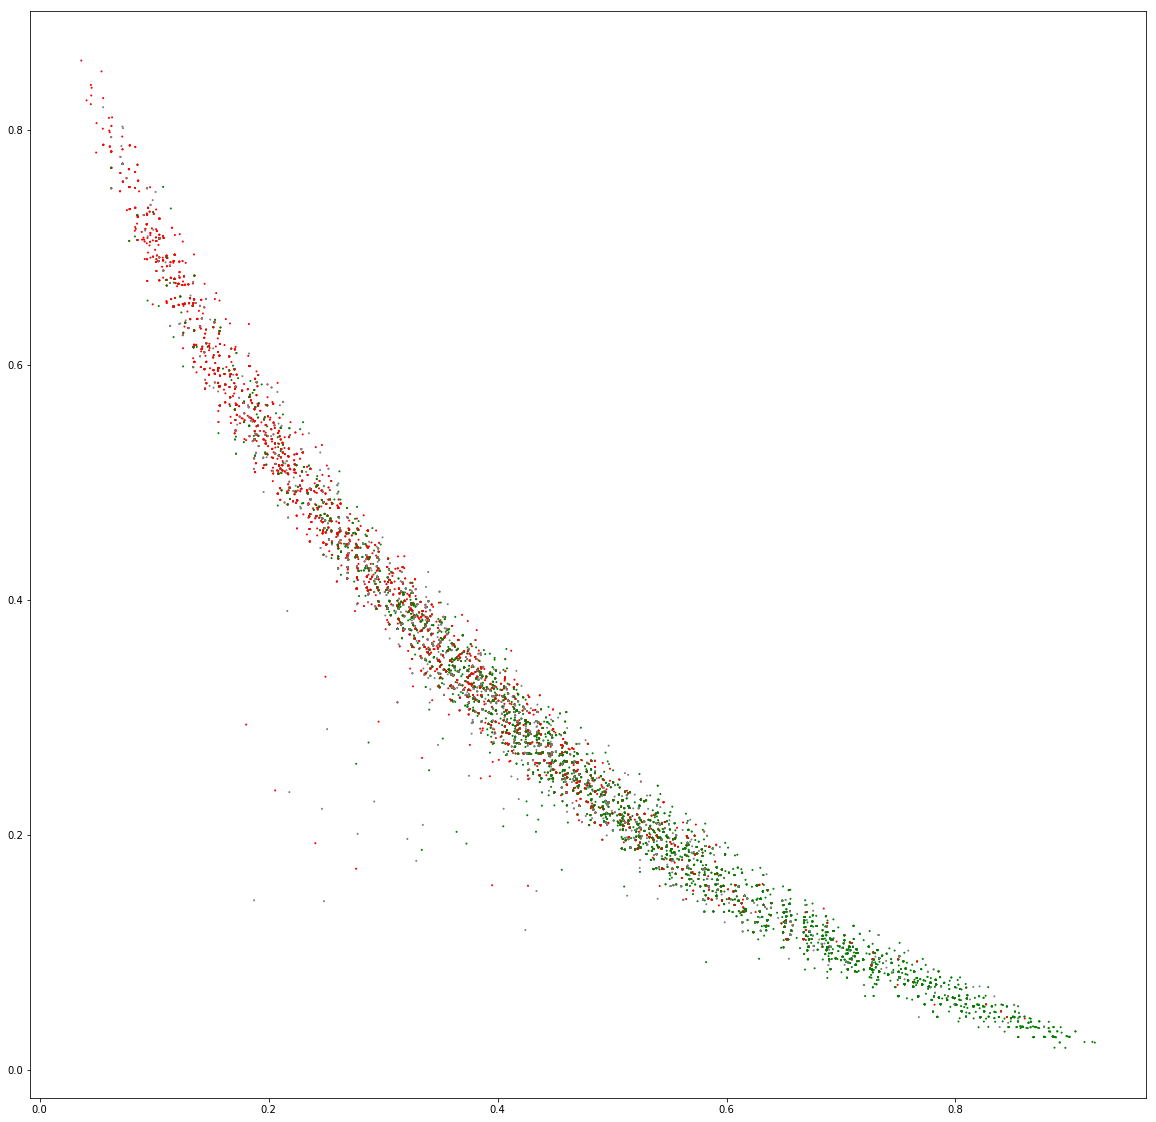

In [8]:
plt.figure(figsize=(20,20))
plt.scatter(x, y, c=c, s=1)
plt.show()

Home
2.17519752097%


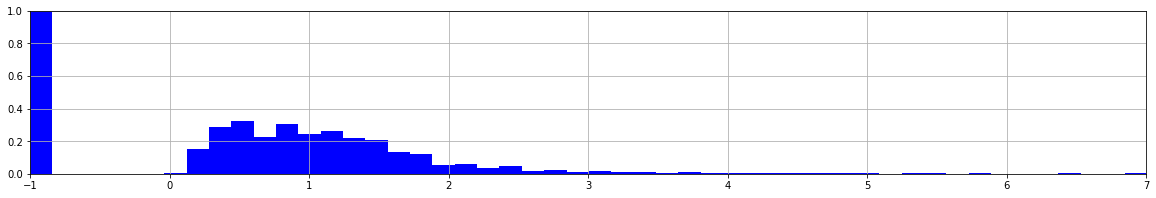

Draw
-4.91713207653%


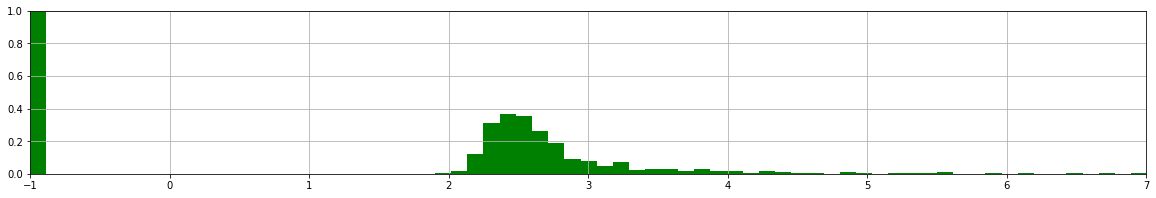

Away
-5.15507594573%


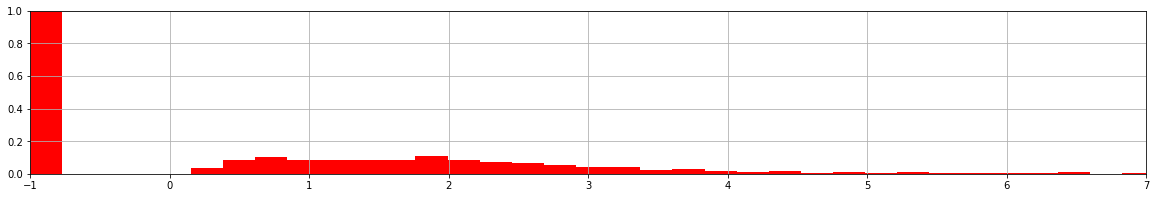

In [9]:
betsOnHome = []
betsOnDraw = []
betsOnAway = []

for match in matches:
    if match['outcome'][0] == 1:
        betsOnHome.append((1 / match['n_probabilities'][0]) - 1)
    else:
        betsOnHome.append(-1)
        
    if match['outcome'][0] == 0.5:
        betsOnDraw.append((1 / match['n_probabilities'][1]) - 1)
    else:
        betsOnDraw.append(-1)
        
    if match['outcome'][0] == 0:
        betsOnAway.append((1 / match['n_probabilities'][2]) - 1)
    else:
        betsOnAway.append(-1)

def hist(data, c):
    print(str(np.sum(data) / len(data) * 100) + "%")
    
    plt.figure(figsize=(20,3))
    plt.hist(data, 100, normed=1, facecolor=c)
    plt.grid(True)
    plt.axis([-1, 7, 0, 1])
    plt.show()

print("Home")
hist(betsOnHome, 'b')

print("Draw")
hist(betsOnDraw, 'g')

print("Away")
hist(betsOnAway, 'r')

import scipy

hOdd = []
dOdd = []
aOdd = []
outcome = []

for match in matches:
    hOdd.append(match['n_probabilities'][0]);
    dOdd.append(match['n_probabilities'][1]);
    aOdd.append(match['n_probabilities'][2]);
    outcome.append(match['outcome'][0]);
    
print(scipy.stats.spearmanr(hOdd, outcome))
print(scipy.stats.spearmanr(dOdd, outcome))
print(scipy.stats.spearmanr(aOdd, outcome))

In [10]:
xData = []
yData = []

for match in matches:
    xData.append([match['n_probabilities'][0], match['n_probabilities'][1], match['n_probabilities'][2]]);
    yData.append(match['outcome']);

In [11]:
import tensorflow as tf

inputLength = len(xData)

x = tf.placeholder(tf.float32, [inputLength, 3], name='X')

Weights = tf.Variable(initial_value = [1.0, 1.0, 1.0], dtype = tf.float32, expected_shape = [3, 1], name='WEIGHTS')
Biases = tf.Variable(initial_value = [0.0, 0.0, 0.0], dtype = tf.float32, expected_shape = [3, 1], name='BIASES')

y = tf.placeholder(tf.float32, shape=[inputLength, 1], name='Y')

learning_rate = tf.placeholder(tf.float32, shape=[])

tiledWeights = tf.tile([Weights], [inputLength, 1], "tiledWEIGHTS")
tiledBiases = tf.tile([Biases], [inputLength, 1], "tiledBIASES")

model = tf.reduce_sum(tf.add(tf.multiply(x, tiledWeights), tiledBiases), 1, keep_dims=True);

loss = tf.reduce_sum(tf.square(tf.subtract(model, y)))
meanloss = tf.reduce_mean(tf.square(tf.subtract(model, y)))

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
train = optimizer.minimize(loss)

init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)
        
    lr = 0.000001
    lastError = 10000000000
    for i in range(30):
        sess.run(train, {x:xData, y:yData, learning_rate:lr})
        lr = lr / 1.01
        error = sess.run([loss], {x:xData, y:yData})[0]; 
        progress = error - lastError
        print(progress)
        lastError = error
        if progress >= 0:
            break
        
    print("#######")
    print(sess.run([Weights, Biases, meanloss], {x:xData, y:yData}))
    
#sess.run([Weights, Biases])
#print(sess.run([Weights, Biases, loss], {x:[[1.0, 2.0, 3.0]], y:[[1.0], [1.0]]}))

-9999993155.95
-771.759
-553.557
-398.612
-288.323
-209.378
-152.783
-112.029
-82.6138
-61.2788
-45.7656
-34.4536
-26.1641
-20.071
-15.5684
-12.2649
-9.78516
-7.93774
-6.55566
-5.51318
-4.74023
-4.14355
-3.6687
-3.31714
-3.05518
-2.82813
-2.66357
-2.51685
-2.41309
-2.31226
#######
[array([ 0.97873527,  0.9638378 ,  0.93444985], dtype=float32), array([-0.12297719, -0.12297719, -0.12297719], dtype=float32), 0.17712888]
